# Predicting The Conditions of Water Holes

**Objective:** In this project, I have to predict whether a water hole is functional, non-functional, or functiona but needs repair. The dataset is freely available from a DrivenData competition. It is also available in Tarrifa and Tanzanian Minsistry of water.

In [142]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score

In [143]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Convert into date column
   # df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    
    
    # Extracting Year from date
    #df['year_recorded'] = df['date_recorded'].dt.year
    
    # A height cannot be a negative number 
    df['gps_height'] = abs(df['gps_height'])
    
    low, high = df["amount_tsh"].quantile([0.1, 0.9])
    mask_total = df["amount_tsh"].between(low, high)
    df = df[mask_total]
    

    # Making these columns boolean
    df['public_meeting'] = df['public_meeting'].fillna('True').astype('bool')
    df['permit'] = df['permit'].fillna('True').astype('bool')
    
    # Filling uo the missing values with the mode
    mode_value = df['scheme_management'].mode()[0]

    # Replace missing values with the mode
    df['scheme_management'] = df['scheme_management'].fillna(mode_value)
    
    # Dropping the observations where longitude = 0
    df = df[df['longitude'] != 0]
    
    
    
    conditions = [
        (df['region'] == 'Arusha'), (df['region'] == 'Dar es Salaam'), (df['region'] == 'Dodoma'), 
        (df['region'] == 'Iringa'), (df['region'] == 'Kagera'), (df['region'] == 'Kigoma'), 
        (df['region'] == 'Kilimanjaro'), (df['region'] == 'Lindi'), (df['region'] == 'Manyara'), 
        (df['region'] == 'Mara'), (df['region'] == 'Mbeya'), (df['region'] == 'Morogoro'), 
        (df['region'] == 'Mtwara'), (df['region'] == 'Mwanza'), (df['region'] == 'Pwani'), 
        (df['region'] == 'Rukwa'), (df['region'] == 'Ruvuma'), (df['region'] == 'Shinyanga'), 
        (df['region'] == 'Singida'), (df['region'] == 'Tabora'), (df['region'] == 'Tanga'), 
    ] 
    
    values = [2, 7, 1, 11, 18, 16, 3, 80, 21, 20, 12, 5, 90, 19, 60, 15, 10, 17, 13, 14, 4]
    
    df['rgcode'] = np.select(conditions, values)
    
    # selecting top 20 lga
    top_20_lga= df["lga"].value_counts().head(20).index
    
    # Assigning the other ten to the group "Other"
    df["lga"]=df["lga"].apply(lambda x: x if x in top_20_lga else "Other" )
    
    # selecting top 25 funders
    top_25_funder= df["funder"].value_counts().head(25).index
    
    # Assigning the other ten to the group "Other"
    df["funder"]=df["funder"].apply(lambda x: x if x in top_25_funder else "Other" )
    
    # selecting top 25 installers
    top_25_installer= df["installer"].value_counts().head(25).index
    
    # Assigning the other ten to the group "Other"
    df["installer"]=df["installer"].apply(lambda x: x if x in top_25_installer else "Other" )
    
    # selecting top  wards
    top_25_ward= df["ward"].value_counts().head(25).index
    
    # Assigning the other ten to the group "Other"
    df["ward"]=df["ward"].apply(lambda x: x if x in top_25_ward else "Other")
    
    # Dropping rows that were inspected before 2011
    #df = df[df['year_recorded'] >= 2011]
    
    #delete unnecessary columns
    df.drop(columns = ['extraction_type_group', 'payment',  'wpt_name',
    'management_group', 'source_type', 'waterpoint_type', 'scheme_name', 'recorded_by', 'region_code', 'subvillage',
     'quality_group', 'quantity_group',  'construction_year', 'extraction_type', 'source_class',
    ], inplace=True)
    
    return df

In [150]:
df = wrangle("tanzaniawaterhole_training.csv")

In [152]:
df.drop(columns = 'Unnamed: 0', inplace=True)

In [153]:
df.head(5)

id  amount_tsh date_recorded  funder  gps_height     installer  \
1   8776         0.0    2013-03-06   Other        1399         Other   
2  34310        25.0    2013-02-25   Other         686  World vision   
3  67743         0.0    2013-01-28  Unicef         263         Other   
4  19728         0.0    2011-07-13   Other           0         Other   
5   9944        20.0    2011-03-13   Other           0           DWE   

   longitude   latitude  num_private                    basin  ... permit  \
1  34.698766  -2.147466            0            Lake Victoria  ...   True   
2  37.460664  -3.821329            0                  Pangani  ...   True   
3  38.486161 -11.155298            0  Ruvuma / Southern Coast  ...   True   
4  31.130847  -1.825359            0            Lake Victoria  ...   True   
5  39.172796  -4.765587            0                  Pangani  ...   True   

   extraction_type_class management payment_type  water_quality      quantity  \
1                gravity        wug    never pay           soft  insufficient   
2                gravity        vwc   per bucket           soft        enough   
3            submersible        vwc    never pay           soft           dry   
4                gravity      other    never pay           soft      seasonal   
5            submersible        vwc   per bucket          salty        enough   

                 source  waterpoint_type_group    status_group rgcode  
1  rainwater harvesting     communal standpipe      functional     20  
2                   dam     communal standpipe      functional     21  
3           machine dbh     communal standpipe  non functional     90  
4  rainwater harvesting     communal standpipe      functional     18  
5                 other     communal standpipe      functional      4  

[5 rows x 27 columns]

In [154]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="latitude",
    lon="longitude",
    width=950,  # Width of map
    height=600,  # Height of map
    color="amount_tsh",
    hover_data=["amount_tsh"], 
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [155]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52841 entries, 1 to 59399
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     52841 non-null  int64  
 1   amount_tsh             52841 non-null  float64
 2   date_recorded          52841 non-null  object 
 3   funder                 52841 non-null  object 
 4   gps_height             52841 non-null  int64  
 5   installer              52841 non-null  object 
 6   longitude              52841 non-null  float64
 7   latitude               52841 non-null  float64
 8   num_private            52841 non-null  int64  
 9   basin                  52841 non-null  object 
 10  region                 52841 non-null  object 
 11  district_code          52841 non-null  int64  
 12  lga                    52841 non-null  object 
 13  ward                   52841 non-null  object 
 14  population             52841 non-null  int64  
 15  pu

In [156]:
null_values = pd.Series(df.isnull().sum()).sort_values(ascending=False)

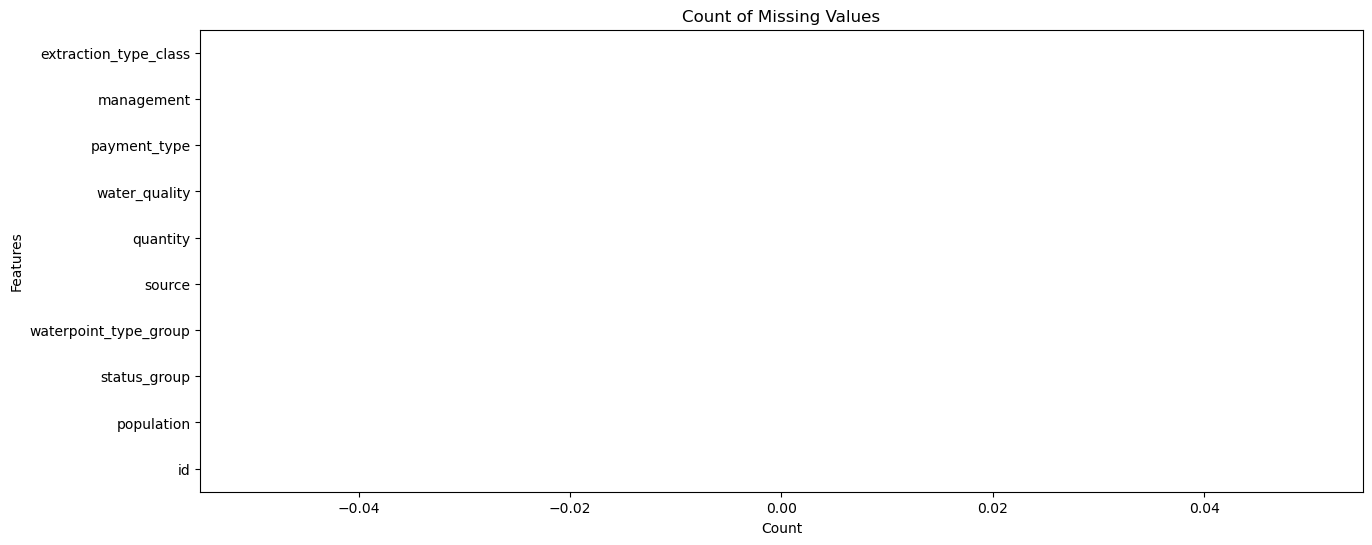

In [157]:
f, ax = plt.subplots(figsize=(15, 6))
null_values.head(10).plot(kind = "barh",
                         xlabel = 'Count',
                         ylabel = 'Features',
                         title = 'Count of Missing Values');

**Distinct Values**
1. Funder = 1898
2. Installer = 2146
3. Lga = 125
4. Ward = 2092
5. Subvillage = 19,288
6. wpt_name = 37,400

*We are going to drop 5 and 6. For 1 to 4, we will keep them. We will take top 10 categories. and group others together

**Notes**

1. Region and and region-code has duplicate values. (this issue is fixed)
2. Funder and installer has funky names

In [158]:
df['installer'].value_counts(normalize=True)

Other                 0.457126
DWE                   0.276660
Government            0.030374
RWE                   0.022009
KKKT                  0.016975
DANIDA                0.016767
Commu                 0.016559
Hesawa                0.015026
0                     0.014572
Central government    0.011714
CES                   0.011544
TCRS                  0.011506
HESAWA                0.010163
Community             0.009614
District Council      0.009576
World vision          0.007721
LGA                   0.007589
WEDECO                0.007513
District council      0.006832
Gover                 0.006699
AMREF                 0.006207
TASAF                 0.005961
TWESA                 0.005886
WU                    0.005526
ACRA                  0.005148
Dmdd                  0.004731
Name: installer, dtype: float64

In [159]:
df.select_dtypes("object").nunique()

date_recorded            352
funder                    26
installer                 26
basin                      9
region                    21
lga                       21
ward                      26
scheme_management         12
extraction_type_class      7
management                12
payment_type               7
water_quality              8
quantity                   5
source                    10
waterpoint_type_group      6
status_group               3
dtype: int64

### Data Cleaning: 

In this dataset, there are several like alike columns. Such as extraction_type and extraction_type_group. Both are categorical columns, so I will keep the one that has more categories. Similarly other pairs are payment and payment_type, water_quality and quality_group, source and source_type, and waterpoint_type and waterpoint_type_group, and will receive the same treatment.

**Record:** Let's see when recording has started and when the last record was made

In [161]:
print("Record Ended On: ", max(df['date_recorded']))
print("Record Started On: ", min(df['date_recorded']))

Record Ended On:  2013-12-03
Record Started On:  2002-10-14


It is seen that the majority of the record has been done between the year 2011 and 2013.

**Filling Up the Missing Values:** What strategy should we use here?. Can we fill it up with mode? 

In [162]:
df["lga"].value_counts().head(12)

Other            33705
Njombe            1974
Moshi Rural       1251
Arusha Rural      1198
Rungwe            1106
Kilosa            1035
Mbozi             1034
Bagamoyo           973
Meru               969
Singida Rural      930
Kilombero          930
Kyela              859
Name: lga, dtype: int64

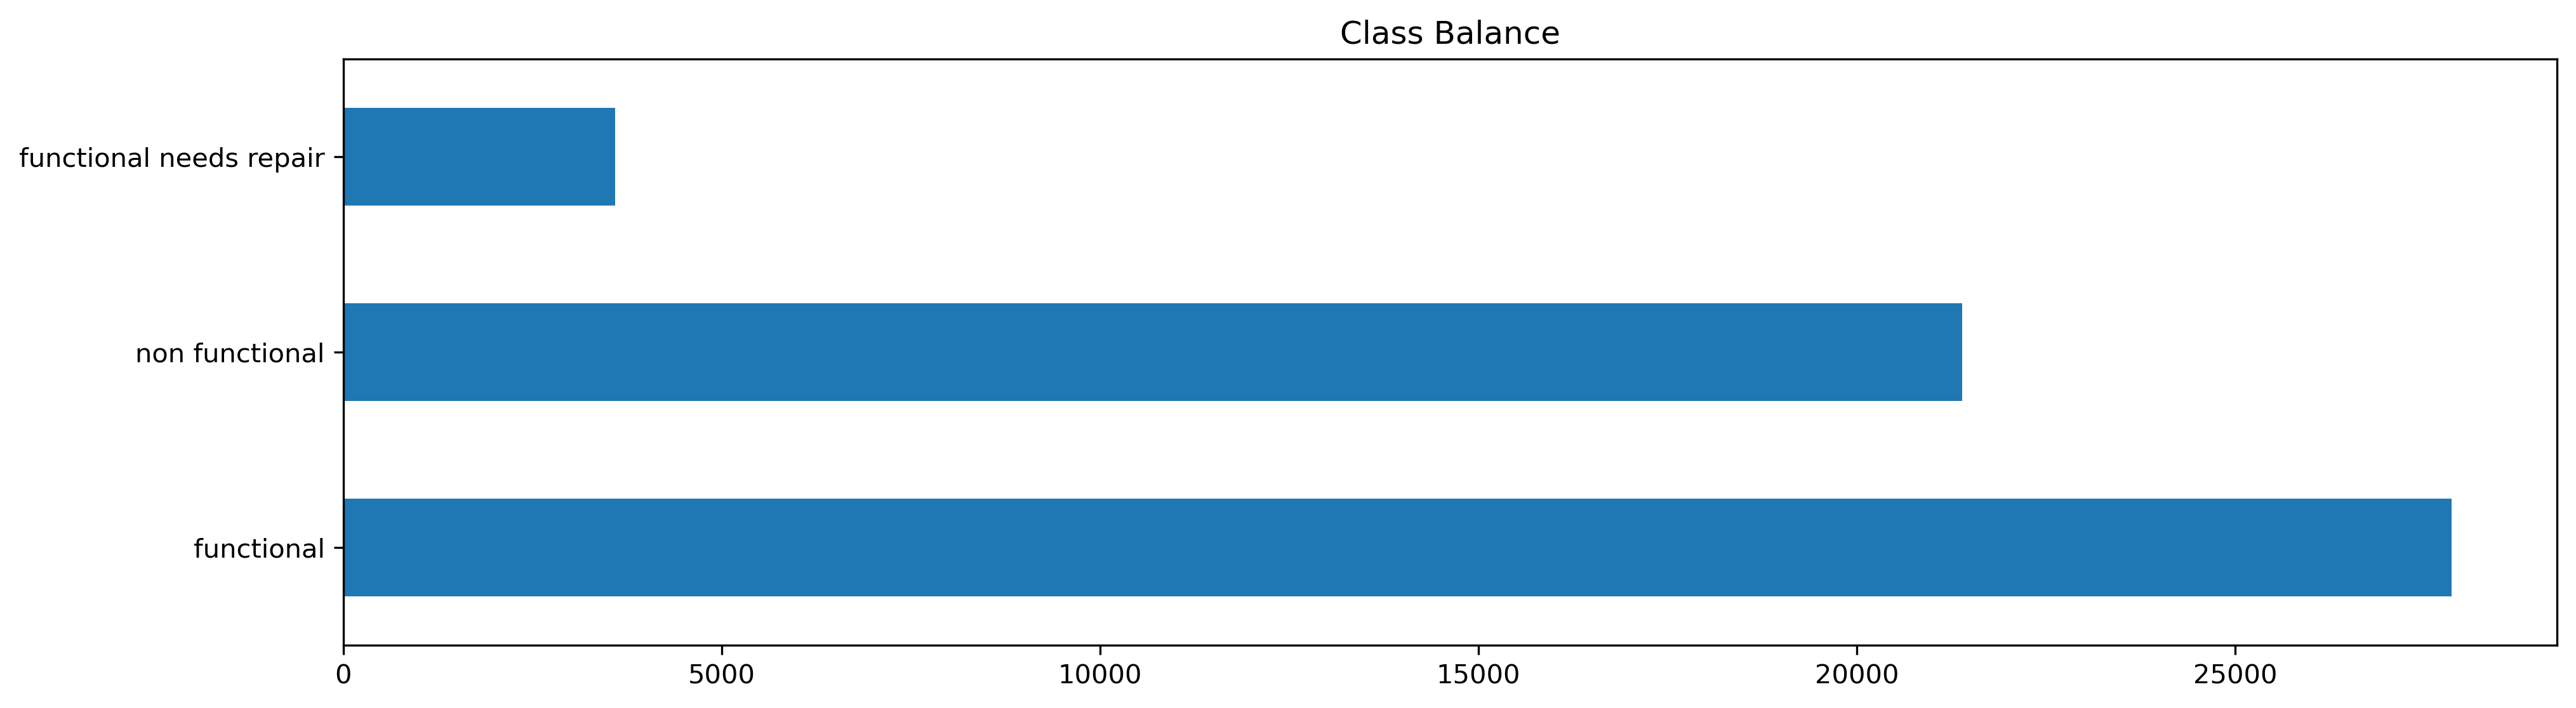

In [163]:
#plotting class balance
fig, ax = plt.subplots(dpi=300, figsize=(15,4))
df["status_group"].value_counts().plot(kind = "barh", title= "Class Balance");

In [164]:
df.drop(columns = 
        ['latitude','longitude', 'rgcode', 'district_code', 
         'population']).describe()

id    amount_tsh    gps_height   num_private
count  52841.000000  52841.000000  52841.000000  52841.000000
mean   37127.486781     45.953196    643.070797      0.495203
std    21455.432481    125.393802    683.262645     12.837147
min        0.000000      0.000000      0.000000      0.000000
25%    18566.000000      0.000000      0.000000      0.000000
50%    37043.000000      0.000000    331.000000      0.000000
75%    55684.000000      0.000000   1301.000000      0.000000
max    74247.000000    500.000000   2770.000000   1776.000000

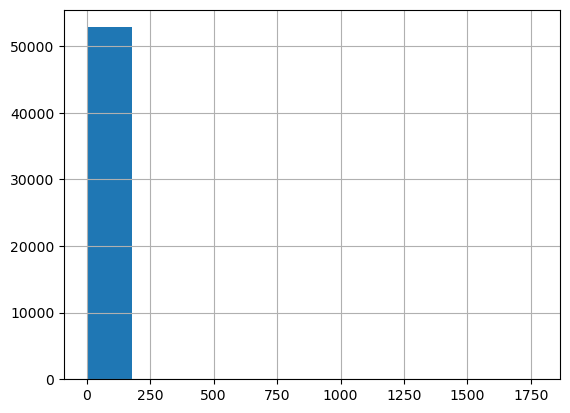

In [165]:
df['num_private'].hist(bins =10);

## Model Building ##
From here, we are now shifting our attention in building the model.

In [166]:
target = "status_group"
X = df.drop(columns = [target])
y = df[target]
print ("X shape:", X.shape)
print ("y shaep:", y.shape)

X shape: (52841, 26)
y shaep: (52841,)


**Task:** Dividing them into randomized train and test set. The test set should have 20% of the data

In [167]:
X_train, X_test, y_train, y_test = train_test_split(
     X,y, test_size=0.2, random_state=42
)

**Task:** Dividing the training set into randomized train and validation set

In [168]:
X_train, X_val, y_train, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=42
)

### Baseline

In [169]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.53


### Iterate

In [170]:
model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth = 6, random_state=42)    
)

# fit the model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['date_recorded', 'funder', 'installer',
                                      'basin', 'region', 'lga', 'ward',
                                      'scheme_management',
                                      'extraction_type_class', 'management',
                                      'payment_type', 'water_quality',
                                      'quantity', 'source',
                                      'waterpoint_type_group'],
                                mapping=[{'col': 'date_recorded',
                                          'data_type': dtype('O'),
                                          'mapping': 2013-02-19      1
2011-03-12      2
2011-07-...
                                          'data_type': dtype('O'),
                                          'mapping': spring                   1
shallow well             2
machine dbh              3
river                    4
rainwater harvesting     5
other                    6
hand dtw                 7
unknown                  8
lake                     9
dam                     10
NaN                     -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe    1
hand pump             2
other                 3
improved spring       4
dam                   5
cattle trough         6
NaN                  -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

**Task:** Training and Validation Accuracy

In [171]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_val, y_val)

print("Training Accuracy:", round(acc_train,2))
print("Validation Accuracy:", round(acc_val,2))

Training Accuracy: 0.72
Validation Accuracy: 0.71


**Task:** Using the get_depth() method, let's find out the depth of the DecisionTreeClassifier

In [172]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth", tree_depth)

Tree Depth 6


**Task:** Get a range of depth 

In [173]:
depth_hyperparameters = range(1, 45, 2)

**Task:** Let's 

In [174]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparameters:
    test_model = make_pipeline(
      OrdinalEncoder(), 
      DecisionTreeClassifier(max_depth=d, random_state=42)    
   )
    # Fit model to training data
    test_model.fit(X_train, y_train)
   
    # Calculate training accuracy and append to the empty list
    training_acc.append(test_model.score(X_train, y_train))
    
    # Calculate validation accuracy and append to the empty list
    validation_acc.append(test_model.score(X_val, y_val))
    
print("Training Accuracy Score:", training_acc[:3])
print("Validation Accuracy Score:", validation_acc[:3])
    

Training Accuracy Score: [0.6201614572552266, 0.6864890439719668, 0.7069521246710234]
Validation Accuracy Score: [0.6173861620342992, 0.6900059136605559, 0.7083382613837965]


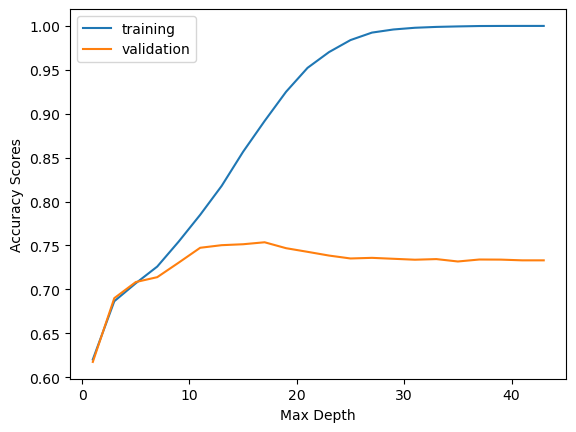

In [175]:
plt.plot(depth_hyperparameters, training_acc, label="training")
plt.plot(depth_hyperparameters, validation_acc, label="validation");
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Scores")
plt.legend();

In [176]:
y_test.head()

41359             non functional
14026                 functional
34624             non functional
3558                  functional
41524    functional needs repair
Name: status_group, dtype: object

In [177]:
test_acc= model.score(X_test, y_test)
print ("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.71


**Task:** Plot Tree

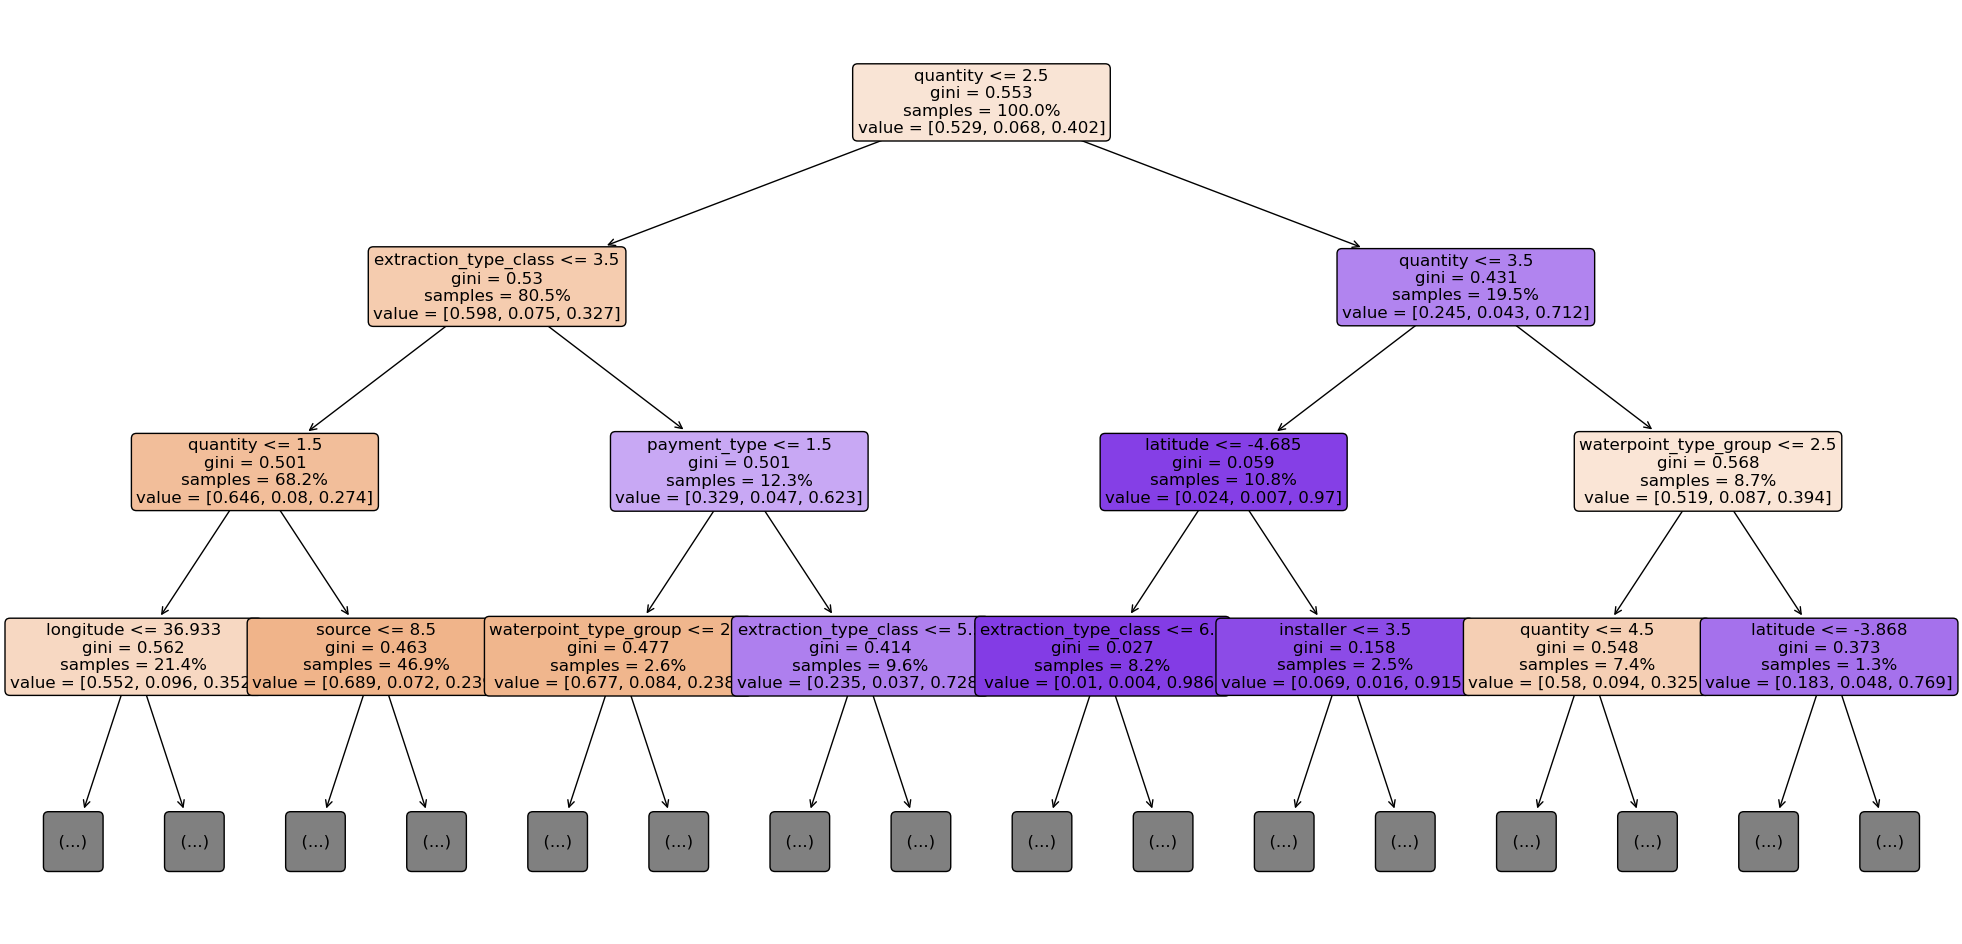

In [178]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [179]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['id', 'amount_tsh', 'date_recorded'], dtype='object')
Importances: [0.00117728 0.01896797 0.00345287]


In [45]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

ward             0.0
water_quality    0.0
funder           0.0
gps_height       0.0
permit           0.0
dtype: float64

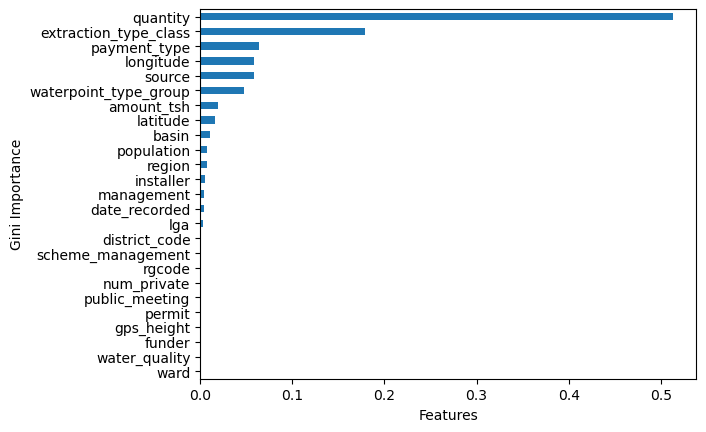

In [180]:
#fig, ax = plt.subplots(figsize=(25, 20))
feat_imp.plot(kind="barh")
plt.xlabel("Features")
plt.ylabel("Gini Importance");

In [212]:
conditions = [
        (test_df['region'] == 'Arusha'), (test_df['region'] == 'Dar es Salaam'), (test_df['region'] == 'Dodoma'), 
        (test_df['region'] == 'Iringa'), (test_df['region'] == 'Kagera'), (test_df['region'] == 'Kigoma'), 
        (test_df['region'] == 'Kilimanjaro'), (test_df['region'] == 'Lindi'), (test_df['region'] == 'Manyara'), 
        (test_df['region'] == 'Mara'), (test_df['region'] == 'Mbeya'), (test_df['region'] == 'Morogoro'), 
        (test_df['region'] == 'Mtwara'), (test_df['region'] == 'Mwanza'), (test_df['region'] == 'Pwani'), 
        (test_df['region'] == 'Rukwa'), (test_df['region'] == 'Ruvuma'), (test_df['region'] == 'Shinyanga'), 
        (test_df['region'] == 'Singida'), (test_df['region'] == 'Tabora'), (test_df['region'] == 'Tanga'), 
    ] 
    
values = [2, 7, 1, 11, 18, 16, 3, 80, 21, 20, 12, 5, 90, 19, 60, 15, 10, 17, 13, 14, 4]
    
test_df['rgcode'] = np.select(conditions, values)

In [217]:
def test_prep(filepath):
    df = pd.read_csv(filepath)
    
   
    
    
    
    # A height cannot be a negative number 
    df['gps_height'] = abs(df['gps_height'])
    
    
    # Making these columns boolean
    df['public_meeting'] = df['public_meeting'].fillna('True').astype('bool')
    df['permit'] = df['permit'].fillna('True').astype('bool')
    
    # Filling uo the missing values with the mode
    mode_value = df['scheme_management'].mode()[0]

    # Replace missing values with the mode
    df['scheme_management'] = df['scheme_management'].fillna(mode_value)
    
    
    
    
    
    conditions = [
        (df['region'] == 'Arusha'), (df['region'] == 'Dar es Salaam'), (df['region'] == 'Dodoma'), 
        (df['region'] == 'Iringa'), (df['region'] == 'Kagera'), (df['region'] == 'Kigoma'), 
        (df['region'] == 'Kilimanjaro'), (df['region'] == 'Lindi'), (df['region'] == 'Manyara'), 
        (df['region'] == 'Mara'), (df['region'] == 'Mbeya'), (df['region'] == 'Morogoro'), 
        (df['region'] == 'Mtwara'), (df['region'] == 'Mwanza'), (df['region'] == 'Pwani'), 
        (df['region'] == 'Rukwa'), (df['region'] == 'Ruvuma'), (df['region'] == 'Shinyanga'), 
        (df['region'] == 'Singida'), (df['region'] == 'Tabora'), (df['region'] == 'Tanga'), 
    ] 
    
    values = [2, 7, 1, 11, 18, 16, 3, 80, 21, 20, 12, 5, 90, 19, 60, 15, 10, 17, 13, 14, 4]
    
    df['rgcode'] = np.select(conditions, values)
    
    # selecting top 20 lga
    top_20_lga= df["lga"].value_counts().head(20).index
    
    # Assigning the other ten to the group "Other"
    df["lga"]=df["lga"].apply(lambda x: x if x in top_20_lga else "Other" )
    
    # selecting top 25 funders
    top_25_funder= df["funder"].value_counts().head(25).index
    
    # Assigning the other ten to the group "Other"
    df["funder"]=df["funder"].apply(lambda x: x if x in top_25_funder else "Other" )
    
    # selecting top 25 installers
    top_25_installer= df["installer"].value_counts().head(25).index
    
    # Assigning the other ten to the group "Other"
    df["installer"]=df["installer"].apply(lambda x: x if x in top_25_installer else "Other" )
    
    # selecting top  wards
    top_25_ward= df["ward"].value_counts().head(25).index
    
    # Assigning the other ten to the group "Other"
    df["ward"]=df["ward"].apply(lambda x: x if x in top_25_ward else "Other")
    
   
    
    #delete unnecessary columns
    df.drop(columns = ['Unnamed: 0', 'extraction_type_group', 'payment',  'wpt_name',
    'management_group', 'source_type', 'waterpoint_type', 'scheme_name', 'recorded_by', 'region_code', 'subvillage',
     'quality_group', 'quantity_group',  'construction_year', 'extraction_type', 'source_class',
    ], inplace=True)
    
    return df

In [218]:
test_df = test_prep('tanzaniawaterhole_test.csv')

In [219]:
test_df.head()

id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0      2-4-2013                   Other        1996   
1  51630         0.0      2-4-2013  Government Of Tanzania        1569   
2  17168         0.0      2-1-2013                   Other        1567   
3  45559         0.0     1-22-2013                   Other         267   
4  49871       500.0     3-27-2013                   Other        1260   

  installer  longitude   latitude  num_private                    basin  ...  \
0     Other  35.290799  -4.059696            0                 Internal  ...   
1       DWE  36.656709  -3.309214            0                  Pangani  ...   
2     Other  34.767863  -5.004344            0                 Internal  ...   
3     Other  38.058046  -9.418672            0  Ruvuma / Southern Coast  ...   
4     Other  35.006123 -10.950412            0  Ruvuma / Southern Coast  ...   

  scheme_management  permit extraction_type_class   management  payment_type  \
0        Parastatal    True                 other   parastatal     never pay   
1               VWC    True               gravity          vwc     never pay   
2               VWC    True                 other          vwc     never pay   
3               VWC    True                 other          vwc       unknown   
4       Water Board    True               gravity  water board       monthly   

   water_quality      quantity                source waterpoint_type_group  \
0           soft      seasonal  rainwater harvesting                 other   
1           soft  insufficient                spring    communal standpipe   
2           soft  insufficient  rainwater harvesting                 other   
3           soft           dry          shallow well                 other   
4           soft        enough                spring    communal standpipe   

  rgcode  
0     21  
1      2  
2     13  
3     80  
4     10  

[5 rows x 26 columns]

In [220]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 14850 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              14850 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   num_private            14850 non-null  int64  
 9   basin                  14850 non-null  object 
 10  region                 14850 non-null  object 
 11  district_code          14850 non-null  int64  
 12  lga                    14850 non-null  object 
 13  ward                   14850 non-null  object 
 14  population             14850 non-null  int64  
 15  pu

In [221]:
# model makes a prediction
preds = model.predict_proba(test_df)
# Convert it to a dataframe
preds = pd.DataFrame(preds)
#get a sample of the preds dataframe
preds.head()

0         1         2
0  0.305556  0.111111  0.583333
1  0.645479  0.110415  0.244106
2  0.436321  0.030660  0.533019
3  0.008110  0.000811  0.991079
4  0.814052  0.044789  0.141159

In [222]:
values = preds.values

In [223]:
print(values)

[[3.05555556e-01 1.11111111e-01 5.83333333e-01]
 [6.45478962e-01 1.10414802e-01 2.44106237e-01]
 [4.36320755e-01 3.06603774e-02 5.33018868e-01]
 ...
 [6.45478962e-01 1.10414802e-01 2.44106237e-01]
 [6.45478962e-01 1.10414802e-01 2.44106237e-01]
 [8.11030008e-03 8.11030008e-04 9.91078670e-01]]


In [224]:
max_column_index = np.argmax(values, axis =1)

In [225]:
print(max_column_index)

[2 0 2 ... 0 0 2]


In [226]:
type(max_column_index)

numpy.ndarray

In [227]:
max_column = preds.columns[max_column_index]

In [228]:
print(max_column)

Int64Index([2, 0, 2, 2, 0, 0, 0, 2, 0, 0,
            ...
            0, 0, 1, 0, 0, 2, 0, 0, 0, 2],
           dtype='int64', length=14850)


In [229]:
type(max_column)

pandas.core.indexes.numeric.Int64Index

In [230]:
submission = pd.DataFrame({
        "id": test_df["id"],
        "status_group": max_column
    })

In [231]:
predictions = pd.DataFrame(max_column)

In [232]:
submission.head()

id  status_group
0  50785             2
1  51630             0
2  17168             2
3  45559             2
4  49871             0

In [233]:
submission["status_group"].value_counts()

0    10986
2     3601
1      263
Name: status_group, dtype: int64

In [234]:
submission_dict={
    0: "functional",
    2:  "non functional",
    1: "functional needs repair"
}

submission['status_group'] = submission['status_group'].map(submission_dict)
submission.head()

id    status_group
0  50785  non functional
1  51630      functional
2  17168  non functional
3  45559  non functional
4  49871      functional

In [237]:
submission.to_csv('submission_tanzaniawaterhole.csv')